In [1]:
from gurobipy import *
import snap
from graphviz import Digraph
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
IP = []
LP_R = []
X_axis = []
for i in range(10,110,10):
    print("目前跑到這裡=",i)
    X_axis.append(i)
    nodes = i
    edges = i*2.5
    print("nodes",nodes)
    print("edges",edges)
    G1 = snap.GenRndGnm(snap.TUNGraph, int(nodes), int(edges))
    #刪除孤單的點
    lonely_node = []
    for NI in G1.Nodes():
        if NI.GetOutDeg()==0:
            lonely_node.append(NI.GetId())
            G1.DelNode(NI.GetId())
    S = 0 #初始感染點(有四個要改)
    AllnodeID = []
    InfectednodeID = [S]
    V = [] #AllnodeID\0(s) #vulnerablenodeID
    vaccinatednodeID = [] #vaccinated的node
    for NI in G1.Nodes():
        AllnodeID.append(NI.GetId())
        if(NI.GetId()!=S):
            V.append(NI.GetId())
            
    layer = 0
    for NI in G1.Nodes():
        if(G1.GetShortPath(NI.GetId(),S)>layer):
            layer = G1.GetShortPath(NI.GetId(),S)
            
#IP Programming
    B = 1 #budget
    S = 0 #初始感染點
    #Create empty model
    IP_model = Model('IP Vaccination Strategy')

    #add variablies
    #S = model.addVars([(u,t) for u in V for t in range(1,layer+1)],vtype=GRB.BINARY, name="S")
    X = IP_model.addVars([(u,t) for u in V for t in range(1,layer+1) ],vtype=GRB.BINARY, name="X")
    Y = IP_model.addVars([(v) for v in V],vtype=GRB.BINARY, name="Y")
    IP_model.update()
    #add objective function
    # obj = 0
    # for v in V:
    #     obj = obj+Y[v]
    IP_model.setObjective(quicksum(Y[v] for v in V) ,GRB.MAXIMIZE)

    #constraint 1
    IP_model.addConstrs(quicksum(X[u,t] for u in V)<=B for t in range(1,layer+1))
    #constraint 2
    #model.addConstrs(quicksum(X[u,t] for t in range(1,layer+1))<=1 for u in V) 
    #constraint 3
    IP_model.addConstrs(quicksum(X[u,t] for u in V for t in range(1,(G1.GetShortPath(S,v)-G1.GetShortPath(u,v))+1) if t>=0 )>= Y[v]  for v in V)
    IP_model.update()
    IP_model.optimize()
    
    IP.append(IP_model.ObjVal)
#LP Programming
    B = 1 #budget
    S = 0 #初始感染點
    #Create empty model
    LP_model = Model('LP Vaccination Strategy')

    #add variablies
    #S = model.addVars([(u,t) for u in V for t in range(1,layer+1)],vtype=GRB.BINARY, name="S")
    X = LP_model.addVars([(u,t) for u in V for t in range(1,layer+1) ],lb=0,ub=1, name="X")
    Y = LP_model.addVars([(v) for v in V],lb=0,ub=1, name="Y")
    LP_model.update()
    #add objective function
    # obj = 0
    # for v in V:
    #     obj = obj+Y[v]
    LP_model.setObjective(quicksum(Y[v] for v in V) ,GRB.MAXIMIZE)

    #constraint 1
    LP_model.addConstrs(quicksum(X[u,t] for u in V)<=B for t in range(1,layer+1))
    #constraint 3
    LP_model.addConstrs(quicksum(X[u,t] for u in V for t in range(1,(G1.GetShortPath(S,v)-G1.GetShortPath(u,v))+1) if t>=0 )>= Y[v]  for v in V)
    LP_model.update()
    LP_model.optimize()
    
    THE_X = [] #取出X[,]
    X_Pro = [] #取出X[,]的機率
    #print("LP Programming")
    #print("保護的個數=",LP_model.ObjVal)
    for var in LP_model.getVars():
        if(var.x>0):
            if(var.varName[0]=="X"):
                THE_X.append(var.varName) 
                X_Pro.append(var.x)
            #print(var.varName,'\t', var.x)
#LP Rounding
    def copy_graph(graph):
        tmpfile = '.copyGraph.bin'

        # Saving to tmp file
        FOut = snap.TFOut(tmpfile)
        graph.Save(FOut)
        FOut.Flush()

        # Loading to new graph
        FIn = snap.TFIn(tmpfile)
        graphtype = type(graph)
        new_graph = graphtype.New()
        new_graph = new_graph.Load(FIn)

        return new_graph
    
    timer = 20
    count = 0
    #print("LP Rounding")
    for i in range(timer):
        print("round=",i)
        random_strategy_choose = [] #新策略(格式很亂)
        new_strategy = []#新策略(格式清理過)
        for i in range(1,layer+1): #以每一個時間抓出來算機率
            XX = [] 
            XX_Pro = []

            for x in range(len(THE_X)):
                if THE_X[x][-4]==",":
                    if THE_X[x][-3:-1]==str(i):
                        XX.append(THE_X[x])
                        XX_Pro.append(X_Pro[x])
                elif THE_X[x][-2]==str(i):
                    XX.append(THE_X[x])
                    XX_Pro.append(X_Pro[x])
            rdc = random.choices(XX, weights=XX_Pro) #這次的策略
            random_strategy_choose.append(rdc)
    #         print( "選擇的是:",rdc )
        for i in range(len(random_strategy_choose)):#清理格式
            if(random_strategy_choose[i][0][-4]==","):
                new_strategy.append(random_strategy_choose[i][0][2:-4])
            else:
                new_strategy.append(random_strategy_choose[i][0][2:-3])

        new_strategy = list(map(int, new_strategy)) #str-->int
        #print("選擇的策略=",new_strategy)
        ########################################################################開始注射策略
        G_temp = copy_graph(G1)
        S = 0 #初始感染點
        temp_vaccinated = []
        temp_infected = [S]
        temp_vulnerable = V.copy()    
        for i in range(len(new_strategy)): #開始依序注射
            temp_saved = []
            b = temp_vulnerable.copy()
            if(new_strategy[i] not in temp_vulnerable): #如果要注射的點已經被保護了(從圖中刪除)
                for n in range(len(b)):
                     if(G_temp.GetShortPath(S,b[n])==i+1):#病毒開始擴散
                        temp_infected.append(b[n])
                        temp_vulnerable.remove(b[n])

                continue

            for k in range(len(temp_vulnerable)):#每一個點計算是否有被注射的點保護

                r  = i+1

                if(r<=(G_temp.GetShortPath(S,temp_vulnerable[k])-G_temp.GetShortPath(new_strategy[i],temp_vulnerable[k]))):
                    temp_saved.append(temp_vulnerable[k])

            for m in range(len(temp_saved)): #調整位置
                temp_vaccinated.append(temp_saved[m])
                temp_vulnerable.remove(temp_saved[m])
                G_temp.DelNode(temp_saved[m])

            a = temp_vulnerable.copy()
            for n in range(len(a)):#病毒開始擴散
                if(G_temp.GetShortPath(S,a[n])==i+1):
                    temp_infected.append(a[n])
                    temp_vulnerable.remove(a[n])


        #print("保護個數=",len(temp_vaccinated))
        count = count+int(len(temp_vaccinated))
    #     print("被保護的點=",temp_vaccinated)

    #print("平均被保護個數=",count/timer)
    LP_R.append(count/timer)

目前跑到這裡= 10
nodes 10
edges 25.0
Academic license - for non-commercial use only - expires 2021-07-24
Using license file C:\Users\user\gurobi.lic
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11 rows, 27 columns and 66 nonzeros
Model fingerprint: 0x9da3b08c
Variable types: 0 continuous, 27 integer (27 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 5 rows and 15 columns
Presolve time: 0.00s
Presolved: 6 rows, 12 columns, 27 nonzeros
Found heuristic solution: objective 5.0000000
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: objective 6.000000e+00, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

Model fingerprint: 0xc307c692
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 11 rows and 52 columns
Presolve time: 0.01s
Presolved: 31 rows, 104 columns, 448 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9000000e+01   2.000000e+01   0.000000e+00      0s
      46    1.6000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.02 seconds
Optimal objective  1.600000000e+01
round= 0
round= 1
round= 2
round= 3
round= 4
round= 5
round= 6
round= 7
round= 8
round= 9
round= 10
round= 11
round= 12
round= 13
round= 14
round= 15
round= 16
round= 17
round= 18
round= 19
目前跑到這裡= 50
nodes 50
edges 125.0
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 53 rows, 245 columns and 1008 nonzeros
Model fingerprint: 

Optimize a model with 83 rows, 468 columns and 4718 nonzeros
Model fingerprint: 0xf368618d
Variable types: 0 continuous, 468 integer (468 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 5 rows and 180 columns
Presolve time: 0.02s
Presolved: 78 rows, 288 columns, 4055 nonzeros
Found heuristic solution: objective 48.0000000
Variable types: 0 continuous, 288 integer (288 binary)

Root relaxation: objective 7.100000e+01, 34 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      71.0000000   71.00000  0.00%     -    0s

Explored 0 nodes (34 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 71 48 -0 

Optim

In [3]:
IP

[6.0, 9.0, 20.0, 16.0, 26.0, 27.0, 35.0, 71.0, 45.0, 62.0]

In [4]:
LP_R

[6.0, 9.0, 20.0, 16.0, 23.25, 24.1, 32.85, 71.0, 45.0, 62.0]

In [5]:
X_axis

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

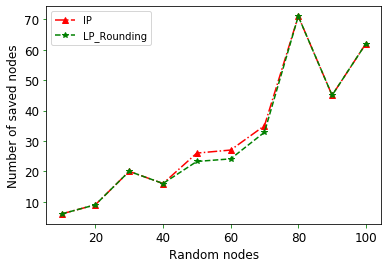

In [6]:
Data_1, = plt.plot(X_axis,IP,'r-.^',label='IP') #畫線
Data_2, = plt.plot(X_axis, LP_R, 'g--*',label='LP_Rounding') #畫線

plt.tick_params(axis='both', labelsize=12, color='green')
plt.legend(handles=[Data_1, Data_2])
plt.xlabel("Random nodes", fontsize=12) #x軸標題
plt.ylabel("Number of saved nodes", fontsize=12) #y軸標題
plt.show() #顯示繪製的圖形